# download the essential packages for NLP  

In [2]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Kiruthik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kiruthik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kiruthik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Imports

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle 
import random
import re
from nltk.corpus import stopwords # to remove stopwords
from nltk.tokenize import word_tokenize # to tokenize the words
from nltk.stem import WordNetLemmatizer # to remove ing 

from sklearn.feature_extraction.text import TfidfVectorizer # for create a vectorizer
from sklearn.svm import SVC  # for classification
from sklearn.pipeline import Pipeline # for sequential execution
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Import training data

In [8]:
def load_intends(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data
# v = load_intends('./intents.json')

# Extract the data  

In [9]:
def preprocess_text(text):
  # lower the text {Hi -> hi}
  text = text.lower()

  # removes the links {http://amazon.com}
  text = re.sub(r'http\S+', '', text)

  # remove any html tags {<br>}
  text = re.sub(r'[<?*>]', '', text)

  # split the words into tokens
  tokens = word_tokenize(text)

  # get the stop words from the nltk library
  stop_words = set(stopwords.words('english'))

  # remove the stop words from the tokens {is, no, yes, read} -> {yes, no, read}
  tokens = [token for token in tokens if token not in stop_words]

  # intialize the lemmatizer
  lemmatizer = WordNetLemmatizer()

  # lemmatize each words in the token { reading -> read }
  tokens = [lemmatizer.lemmatize(token) for token in tokens]

  # Join tokens back into text
  processed_text = ' '.join(tokens)

  return processed_text

In [10]:
intends = load_intends("./intents.json").get('intents')
patterns = []
tags = []
responses = {}


for intent in intends:
    tag = intent['tag']
    responses[tag] = intent['responses']

    for pattern in intent['patterns']:
        preprocessed_text = preprocess_text(pattern)
        patterns.append(preprocessed_text)
        tags.append(tag)

print("Data extracted from intents.json")
print("Number of patterns:", len(patterns))
print("Number of unique tags:", len(set(tags)))
print("Tags:", set(tags))

Data extracted from intents.json
Number of patterns: 38
Number of unique tags: 7
Tags: {'payments', 'greeting', 'thanks', 'cancel', 'delivery', 'goodbye', 'book'}


# Model Building and Training 

In [11]:
# split the datasets
x_train, x_test,y_train, y_test = train_test_split(patterns, tags, test_size=0.2)
print(f"x_train : {len(x_train)}, x_test: {len(x_test)}, y_train : {len(y_train)}, y_test : {len(y_test)}")

x_train : 30, x_test: 8, y_train : 30, y_test : 8


In [12]:
"""
Model Outline
PipeLine() { -> used for step by step execution
    - vectorizer('tfidfVectorizer') -> count the frequency of the words and create a map of it
    - Classifier('SVC') -> using the vector of words classify among the tags
}
"""


model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC(kernel='linear'))
])

In [13]:
model.fit(x_train, y_train)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


# Model evaluation

e:\py\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\py\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\py\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\py\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Reca

Accuracy: 0.625
Confusion Matrix:
 [[1 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 2 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]]
Classification Report:
               precision    recall  f1-score   support

        book       1.00      1.00      1.00         1
      cancel       1.00      1.00      1.00         2
    delivery       1.00      1.00      1.00         2
     goodbye       0.00      0.00      0.00         1
    greeting       0.00      0.00      0.00         0
      thanks       0.00      0.00      0.00         2

    accuracy                           0.62         8
   macro avg       0.50      0.50      0.50         8
weighted avg       0.62      0.62      0.62         8



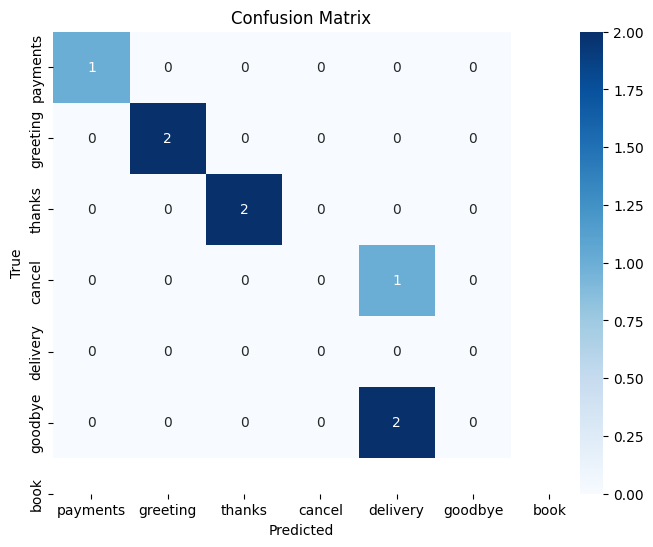

In [14]:
# function for evaluating all the three models
def evaluate_model(model, x_test, y_test):
    # predict the x_test
    y_pred = model.predict(x_test)

    # calculate the accuracy_score
    accuracy = accuracy_score(y_test, y_pred)

    # build a confussion matrix for sns heatmap 
    confusion = confusion_matrix(y_test, y_pred)

    # generate a classification report
    classification_rep = classification_report(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", confusion)
    print("Classification Report:\n", classification_rep)

    # plot the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=set(tags), yticklabels=set(tags))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

evaluate_model(model=model, x_test=x_test, y_test=y_test)

# custom testing

In [15]:
testcases =  {"hi": "greetings", "how do i refund": "payment", "i can't get the food":"delivery"}

for user_input, user_output in testcases.items():
    preprocessed_text = preprocess_text(user_input)
    result = model.predict([preprocessed_text])[0]
    print(f"given statement :{user_input} \n predicted output : {result} \n expected output : {user_output}")

given statement :hi 
 predicted output : greeting 
 expected output : greetings
given statement :how do i refund 
 predicted output : cancel 
 expected output : payment
given statement :i can't get the food 
 predicted output : greeting 
 expected output : delivery


# Export the model as pickle file format    

In [16]:
with open('ChatBot.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# live chatting

In [ ]:
def get_response(user_input):
    processed_input = preprocess_text(user_input)

    predicted_tag = model.predict([processed_input])[0]

    return random.choice(responses[predicted_tag])

while True:
    user_input = input()
    print("You : ", user_input)
    if user_input.lower() in ["quit", "stop", "bye"]:
        print("ChatBot : GoodBye!")
        break
    response = get_response(user_input)
    print("ChatBot :", response)